# Putting All Together

A continuación se realizará un resumen del workflow de PyTorch indagado en el notebook anterior (*01_pytorch_workflow.ipynb*)

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
torch.__version__

'2.5.1+cu124'

## 0. Agnostic Device

Definimos código agnostico a device, pidiendo que éste utilice `cuda` en caso de existir, de lo contrario utilizar cpu.

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Data

Definimos un simple dataset para utilizar con nuestro modelo.

En este caso se utilizará la ecuación lineal para definir el data set.

$$y = w X + b$$

In [4]:
# Definimos peso y bias
weight = 0.8
bias = 0.2

# Creamos el dataset
X = torch.arange(start=0, end=1, step=0.02)

# Convertimos el vector de n elementos generado 
# en una matriz de n x 1 para utilizar con los métodos.
X = X.unsqueeze(dim=1)
y = weight * X + bias

X[:5], y[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.2000],
         [0.2160],
         [0.2320],
         [0.2480],
         [0.2640]]))

Separamos el dataset en train y test:

In [5]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

Definimos una función para visualizar la data:

In [6]:
def plot_pred(train_data = X_train, train_labels = y_train,
              test_data = X_test, test_labels = y_test,
              predictions = None):
    """
    Grafica los datos de entrenamiento, testing
    y los compara con las predicciones del modelo
    """
    
    plt.figure(figsize = (10, 7))
    plt.scatter(x = train_data, y = train_labels, 
                c="b", s=4, label = "Training Data")
    plt.scatter(x = test_data, y = test_labels, 
                c="purple", s=4, label = "Test Data")
    if predictions is not None:
        plt.scatter(x = test_data, y = predictions, 
                c="r", s=4, label = "Predictions")
    plt.legend(prop={"size":14})


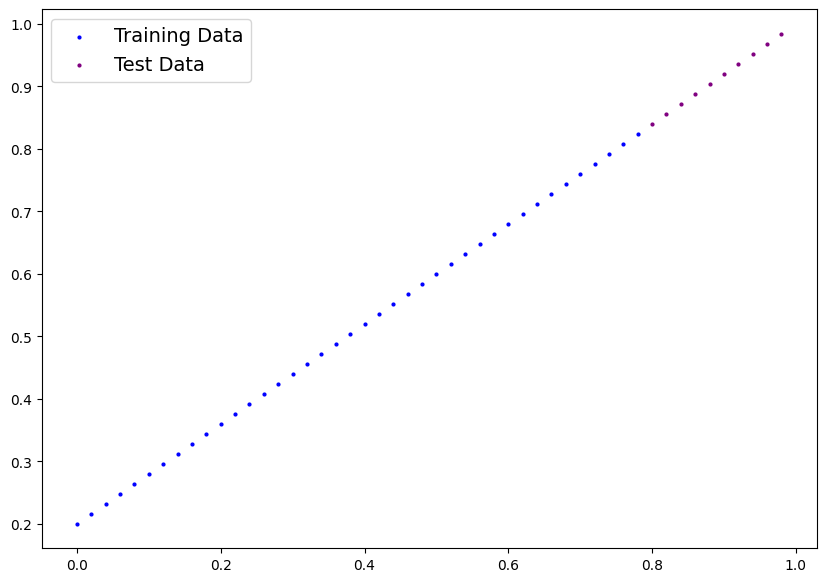

In [7]:
plot_pred()

## 2. Crear Modelo

Definimos la clase del modelo heredando de `nn.Module`.

Sin embargo, en lugar de crear los parámetros manualmente, se utiliza `nn.Linear()` para definir un `layer`.

Para el uso de `nn.Linear()`:

* `in_features`: Es el tamaño de cada muestra de entrada
* `out_features`: Es el tamaño de cada muestra de salida

Documentación: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

In [8]:
class RegresionLineal(nn.Module):
    def __init__(self):
        super().__init__()
        # Al crear el layer se especifíca 1 input y 1 output 
        # en cada capa
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

Creamos una instancia de la clase y utilizamos una random seed para repetir resultados, sin embargo, esto último es optativo

In [9]:
torch.manual_seed(42)
model1 = RegresionLineal()
model1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

Revisamos el device del modelo:

In [10]:
next(model1.parameters()).device

device(type='cpu')

Por defecto se crea en el cpu, por lo tanto, lo movemos al gpu:

In [11]:
model1.to(device)
next(model1.parameters()).device

device(type='cuda', index=0)

## 3. Entrenamiento y Prueba del Modelo

Para el entrenamiento necesitamos:

* Función de pérdida
* Optimizador
* Bucle de entrenamiento
* Bucle de prueba

Empezamos definiendo la función de pérdida y el optimizador:

In [12]:
loss_fn = nn.L1Loss() # MAE
optimizer = torch.optim.SGD(params=model1.parameters(),
                            lr=0.01)

Nos aseguramos de que todos los datos se encuentren en el device correcto:

In [13]:
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

Creamos una función para el loop de training:

torch.manual_seed(42)
epochs = 200
for epoch in range(epochs):
    model1.train()
    # Forward Pass
    y_pred = model1(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [14]:
def entrenar(modelo:RegresionLineal, optimizador:torch.optim.SGD, loss_f:torch.nn.L1Loss, 
             train_data:torch.Tensor, train_labels:torch.Tensor, epocas:int):
    
    train_losses = []
    
    for epoca in range(epocas):
        modelo.train()

        train_pred = modelo(train_data)
        
        loss = loss_f(train_pred, train_labels)
        train_losses.append(loss.item())

        optimizador.zero_grad()
        loss.backward()
        optimizador.step()

        if epoca % 50 == 0:
            print(f"Epoch: {epoca} | Train Loss: {loss.item()}")
    
    return train_pred, train_losses

Creamos una función para el loop de testing:

In [15]:
def evaluar(modelo:RegresionLineal, loss_f:torch.nn.L1Loss,
           test_data:torch.Tensor, test_labels:torch.Tensor, epocas:int):
    
    test_losses = []
    predicciones = []

    for epoca in range(epocas):
        modelo.eval()
        with torch.inference_mode():
            test_pred = modelo(test_data)
            predicciones.append(test_pred)

            loss = loss_f(test_pred, test_labels)
            test_losses.append(loss.item())

            if epoca % 50 == 0:
                print(f"Epoch: {epoca} | Test Loss: {loss.item()}")
    
    return predicciones, test_losses

Realizamos el entrenamiento:

In [16]:
epochs = 201

In [17]:
train_preds, train_losses = entrenar(modelo=model1, 
                                      optimizador=optimizer, 
                                      loss_f=loss_fn, 
                                      train_data=X_train, 
                                      train_labels=y_train, 
                                      epocas=epochs)

Epoch: 0 | Train Loss: 0.6161779165267944
Epoch: 50 | Train Loss: 0.05875825881958008
Epoch: 100 | Train Loss: 0.03144557774066925
Epoch: 150 | Train Loss: 0.014275657944381237
Epoch: 200 | Train Loss: 0.008990190923213959


In [18]:
type(train_preds), type(train_losses)

(torch.Tensor, list)

In [19]:
train_preds[:5]

tensor([[0.2095],
        [0.2255],
        [0.2415],
        [0.2574],
        [0.2734]], device='cuda:0', grad_fn=<SliceBackward0>)

In [20]:
train_losses[-5:]

[0.008990190923213959,
 0.0025308155454695225,
 0.008990190923213959,
 0.0025308155454695225,
 0.008990190923213959]

In [21]:
test_preds, test_losses = evaluar(modelo=model1,
                                  loss_f=loss_fn,
                                  test_data=X_test,
                                  test_labels=y_test,
                                  epocas=epochs)

Epoch: 0 | Test Loss: 0.005145949311554432
Epoch: 50 | Test Loss: 0.005145949311554432
Epoch: 100 | Test Loss: 0.005145949311554432
Epoch: 150 | Test Loss: 0.005145949311554432
Epoch: 200 | Test Loss: 0.005145949311554432


In [22]:
type(test_preds), type(test_losses)

(list, list)

In [23]:
test_preds[0][:5]

tensor([[0.8353],
        [0.8512],
        [0.8671],
        [0.8830],
        [0.8989]], device='cuda:0')

Los parámetros del modelo después del entrenamiento son muy similares a los utilizados para crear el dataset:

In [24]:
model1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7948]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.1995], device='cuda:0'))])

In [25]:
weight, bias

(0.8, 0.2)

## 4. Realizar y Evaluar Predicciones:

In [26]:
model1.eval()
with torch.inference_mode():
    y_preds = model1(X_test)
y_preds

tensor([[0.8353],
        [0.8512],
        [0.8671],
        [0.8830],
        [0.8989],
        [0.9148],
        [0.9307],
        [0.9466],
        [0.9625],
        [0.9784]], device='cuda:0')

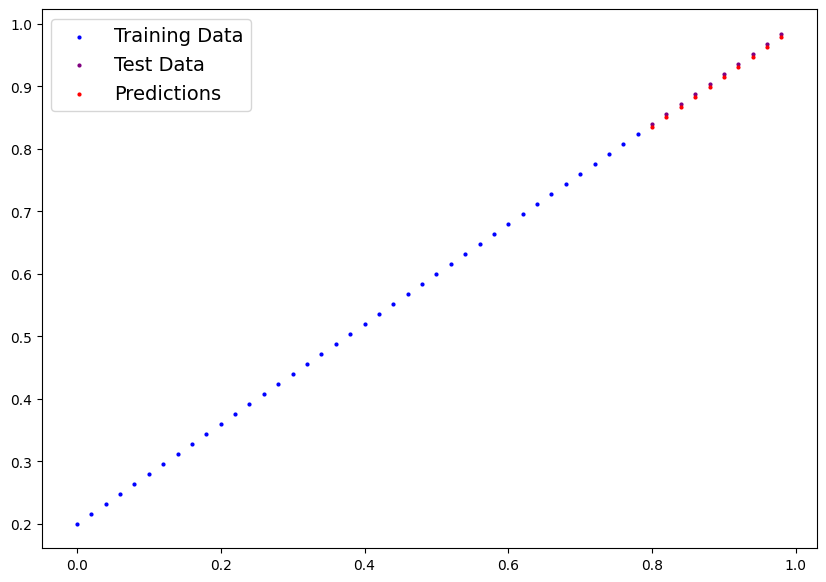

In [27]:
plot_pred(predictions=y_preds.cpu())

## 5. Guardar y Cargar un Modelo

### Guardar el Modelo:

In [28]:
import os

In [29]:
save_dir = os.path.join(os.pardir, os.pardir, 'modelos')
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, "02_summary_model1.pth")

torch.save(model1.state_dict(), save_path)
print(f"Modelo guardado en: {save_path}")

Modelo guardado en: ../../modelos/02_summary_model1.pth


### Cargar el Modelo:

In [30]:
load_path = os.path.join(os.pardir, os.pardir, 
                         'modelos', '02_summary_model1.pth')

if os.path.isfile(load_path):
    loaded_model1 = RegresionLineal()
    loaded_model1.load_state_dict(torch.load(load_path))
    loaded_model1.eval()
    print(f"Modelo cargado correctamente desde: {load_path}")
else:
    raise FileNotFoundError(f"No se encontró en: {load_path} ")

Modelo cargado correctamente desde: ../../modelos/02_summary_model1.pth


/tmp/ipykernel_10187/2223168783.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model1.load_state_dict(torch.load(load_path))


In [31]:
loaded_model1.to(device)

RegresionLineal(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

### Evaluación del Modelo y Comparación con el Original

In [32]:
loaded_model1.eval()
with torch.inference_mode():
    loaded_model1_preds = loaded_model1(X_test)
loaded_model1_preds

tensor([[0.8353],
        [0.8512],
        [0.8671],
        [0.8830],
        [0.8989],
        [0.9148],
        [0.9307],
        [0.9466],
        [0.9625],
        [0.9784]], device='cuda:0')

In [33]:
y_preds

tensor([[0.8353],
        [0.8512],
        [0.8671],
        [0.8830],
        [0.8989],
        [0.9148],
        [0.9307],
        [0.9466],
        [0.9625],
        [0.9784]], device='cuda:0')

In [34]:
y_preds == loaded_model1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')